In [38]:
import chess
import random
from IPython.display import clear_output, display
import time
import numpy as np
import itertools

C = np.sqrt(2)

In [39]:
class Node:
    def __init__(self, board=None, parent=None):
        self.board = board
        self.utility = 0
        self.n_playthrough = 0
        self.parent = parent
        self.children = list()
    
    def peek(self):
        return self.board.peek()


In [47]:
from functools import lru_cache

def select(tree):
    while tree.children:
        tree = max(tree.children, key=lambda k: UCB1(k.utility, k.n_playthrough, k.parent.n_playthrough))

    return tree

def expand(leaf):
    assert not leaf.children, 'This guy is not a leaf'
    
    if leaf.board.legal_moves:
        all_moves = list(leaf.board.legal_moves)
        
        s = 20
        
        if len(all_moves) < s:
            s = len(all_moves)

        rng = np.random.default_rng()
        moves = rng.choice(all_moves, size=s, replace=False)

        for move in moves:
            leaf.board.push(move)
            leaf.children.append(Node(leaf.board.copy(), leaf))
            leaf.board.pop()
        return leaf.children
    # if the current node is checkmated, i.e. no legal moves
    # then return the current node
    return [leaf]

def simulate(child):
    _board = child.board.copy()
    
    while not _board.is_game_over():
        all_moves = list(_board.legal_moves)
        capture_moves = [x for x in all_moves if _board.is_capture(x)]
        check_moves = [x for x in all_moves if _board.gives_check(x)]
        if not capture_moves and not check_moves:
            move = random.choice(all_moves)
        elif not check_moves:
            move = random.choice(capture_moves)
        else:
            move = random.choice(check_moves)

#         move = max(_board.legal_moves, key=lambda x: eval_move(_board, x))
        _board.push(move)


        # simulate would take forever without this if statement
        # basically the game would go on forever with 2 kings moving around without this check
        if _board.has_insufficient_material(_board.turn) or _board.can_claim_fifty_moves():
            return not _board.turn

    return _board.outcome().winner

@lru_cache(maxsize=10000)
def UCB1(U_n, N_n, P_n):
    return U_n/N_n + C*np.sqrt(np.log(P_n)/N_n)

def back_prop(result, child):
    while child:
        child.n_playthrough += 1
        
        if not result == child.board.turn:
            child.utility += 1

        child = child.parent

class MonteCarloAgent:
    
    # main function for the Monte Carlo Tree Search
    def monte_carlo_tree_search(self, board, iterations):
        tree = Node(board)
        for _ in range(iterations):
            leaf = select(tree)

            children = expand(leaf)
            
            results = map(simulate, children)
            
            for result, child in zip(results, children):
                back_prop(result, child)
            
        return max(tree.children, key=lambda k: k.n_playthrough).peek(), tree.n_playthrough



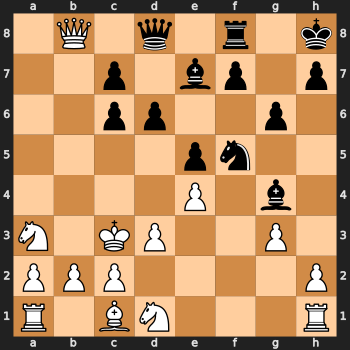

'True'

'n_playthrough=200'

In [ ]:
import cProfile
import pstats
import chess.svg

SCENARIO_1 = '4k3/4P3/3P4/5K2/8/8/1p6/8 w - - 0 1'
SCENARIO_2 = '8/3k4/8/8/8/3K4/3R4/3R4 w - - 0 1'
SCENARIO_3 = 'r1bqk1nr/ppp1bppp/3p4/n3p3/2B1P3/2NP1N2/PPP2PPP/R1BQK2R w KQkq - 1 6'

agent = MonteCarloAgent()
n = 0
board = chess.Board(SCENARIO_3)

with cProfile.Profile() as pr:
    while not board.is_game_over():
        clear_output(wait=True)
        display(chess.svg.board(board, size=350))
        display(f'{board.turn}')
        display(f'n_playthrough={n}')
        if board.turn:
            action, n = agent.monte_carlo_tree_search(board.copy(stack=False), 100)
        else:
            action, n = agent.monte_carlo_tree_search(board.copy(stack=False), 10)
        board.push(action)

display(chess.svg.board(board, size=350))
display(board.outcome())
display(f'n_playthrough={n}')


In [35]:
stats = pstats.Stats(pr)
stats.sort_stats(pstats.SortKey.TIME)
stats.print_stats()

         9469954 function calls (9469461 primitive calls) in 5.710 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   431760    0.685    0.000    0.685    0.000 C:\Users\engli\anaconda3\lib\site-packages\chess\__init__.py:753(_attackers_mask)
   119957    0.577    0.000    1.583    0.000 C:\Users\engli\anaconda3\lib\site-packages\chess\__init__.py:2140(push)
    88659    0.256    0.000    0.256    0.000 <ipython-input-25-7359dda7fe2e>:57(UCB1)
   240694    0.252    0.000    0.325    0.000 C:\Users\engli\anaconda3\lib\site-packages\chess\__init__.py:3136(is_castling)
   181024    0.235    0.000    2.191    0.000 C:\Users\engli\anaconda3\lib\site-packages\chess\__init__.py:3488(generate_legal_moves)
   239914    0.218    0.000    0.311    0.000 C:\Users\engli\anaconda3\lib\site-packages\chess\__init__.py:849(_remove_piece_at)
   219450    0.190    0.000    0.465    0.000 C:\Users\engli\anaconda3\lib\site-packages\chess\__init

In [96]:
board.outcome()


Outcome(termination=<Termination.FIVEFOLD_REPETITION: 5>, winner=None)